In [1]:
import os
import xml.etree.ElementTree as ET
import json

In [2]:
!unzip '/content/drive/MyDrive/Object Detection/archive (85).zip'

Archive:  /content/drive/MyDrive/Object Detection/archive (85).zip
replace README.md? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: README.md               
  inflating: annotated-images/img-1.jpg  
  inflating: annotated-images/img-1.xml  
  inflating: annotated-images/img-10.jpg  
  inflating: annotated-images/img-10.xml  
  inflating: annotated-images/img-100.jpg  
  inflating: annotated-images/img-100.xml  
  inflating: annotated-images/img-101.jpg  
  inflating: annotated-images/img-101.xml  
  inflating: annotated-images/img-102.jpg  
  inflating: annotated-images/img-102.xml  
  inflating: annotated-images/img-103.jpg  
  inflating: annotated-images/img-103.xml  
  inflating: annotated-images/img-104.jpg  
  inflating: annotated-images/img-104.xml  
  inflating: annotated-images/img-105.jpg  
  inflating: annotated-images/img-105.xml  
  inflating: annotated-images/img-106.jpg  
  inflating: annotated-images/img-106.xml  
  inflating: annotated-images/img-107.jpg  
  infl

**Create Folder structure**

In [3]:

import os
from pathlib import Path
import logging

logging.basicConfig(level=logging.INFO, format='[%(asctime)s]: %(message)s')

project_name = 'Pothole_Detection'

list_of_files = [
    f"{project_name}/images/train",
    f"{project_name}/images/val",
    f"{project_name}/labels/train",
    f"{project_name}/labels/val",
    f"{project_name}/splits.json",
    f"{project_name}/README.md"
]

for filepath in list_of_files:
    path = Path(filepath)

    if path.suffix:  # Check if path is a file
        # Create parent directories
        if not path.parent.exists():
            path.parent.mkdir(parents=True, exist_ok=True)
            logging.info(f"Creating directory: {path.parent}")

        # Create file if it doesn't exist or if it is empty
        if not path.exists() or path.stat().st_size == 0:
            path.touch()
            logging.info(f"Creating file: {path}")
    else:  # Path is a directory
        path.mkdir(parents=True, exist_ok=True)
        logging.info(f"Creating directory: {path}")


**Move file to our newly created Folders**

In [4]:
import shutil

# Load splits file
splits_file = 'splits.json'
annotated_images = '/content/annotated-images'
with open(splits_file, 'r') as file:
    splits = json.load(file)

# Function to move files
def move_files(file_list, split_type):
    for xml_file in file_list:
        image_file = xml_file.replace('.xml', '.jpg')  # Corresponding image file

        # Define source paths
        src_image_path =Path(annotated_images) / image_file
        src_xml_path = Path(annotated_images) / xml_file

        # Define destination paths
        dest_image_path = Path(project_name) / 'images' / split_type / image_file
        dest_xml_path = Path(project_name) / 'labels' / split_type / xml_file

        # Move image file
        if src_image_path.exists():
            shutil.move(str(src_image_path), str(dest_image_path))
        else:
            print(f"Warning: {src_image_path} does not exist")

        # Move xml file
        if src_xml_path.exists():
            shutil.move(str(src_xml_path), str(dest_xml_path))
        else:
            print(f"Warning: {src_xml_path} does not exist")

# Move train files
move_files(splits.get('train', []), 'train')

# Move validation files
move_files(splits.get('test', []), 'val')

print("Files moved successfully!")

Files moved successfully!


**Convert XML Annotations to YOLO Format**

In [5]:


import os
import xml.etree.ElementTree as ET

# Define the parent directory and subdirectories
parent_directory = 'Pothole_Detection'
images_dir = os.path.join(parent_directory, 'images')
labels_dir = os.path.join(parent_directory, 'labels')

# Ensure the labels/train and labels/val directories exist
os.makedirs(os.path.join(labels_dir, 'train'), exist_ok=True)
os.makedirs(os.path.join(labels_dir, 'val'), exist_ok=True)

# Function to convert XML to YOLOv8 format
def convert_xml_to_yolo(xml_file, output_txt_file):
    tree = ET.parse(xml_file)
    root = tree.getroot()

    # Extract image dimensions
    size = root.find('size')
    width = int(size.find('width').text)
    height = int(size.find('height').text)

    yolo_annotations = []

    # Extract object information
    for obj in root.findall('object'):
        cls_name = obj.find('name').text
        # Assuming 'pothole' class has an ID of 0; modify as per your class ID
        cls_id = 0 if cls_name == 'pothole' else -1
        if cls_id == -1:
            continue

        bndbox = obj.find('bndbox')
        xmin = int(bndbox.find('xmin').text)
        ymin = int(bndbox.find('ymin').text)
        xmax = int(bndbox.find('xmax').text)
        ymax = int(bndbox.find('ymax').text)

        # Normalize the coordinates
        x_center = (xmin + xmax) / 2 / width
        y_center = (ymin + ymax) / 2 / height
        bbox_width = (xmax - xmin) / width
        bbox_height = (ymax - ymin) / height

        yolo_annotations.append(f"{cls_id} {x_center:.6f} {y_center:.6f} {bbox_width:.6f} {bbox_height:.6f}")

    # Save to corresponding txt file
    with open(output_txt_file, 'w') as f:
        f.write('\n'.join(yolo_annotations))

    # Remove the original XML file
    os.remove(xml_file)

# Process all XML files in the labels/train and labels/val directories
for split in ['train', 'val']:
    xml_files_dir = os.path.join(labels_dir, split)
    output_txt_dir = os.path.join(labels_dir, split)

    for xml_filename in os.listdir(xml_files_dir):
        if xml_filename.endswith('.xml'):
            xml_path = os.path.join(xml_files_dir, xml_filename)
            txt_filename = xml_filename.replace('.xml', '.txt')
            txt_path = os.path.join(output_txt_dir, txt_filename)
            convert_xml_to_yolo(xml_path, txt_path)

print("Conversion completed successfully!")


Conversion completed successfully!


**Generating .yaml file**


In [12]:
import os

parent_directory = '/content/Pothole_Detection'
images_dir = os.path.join(parent_directory, 'images')

# Class names
classes = ['pothole']

# YAML content
yaml_content = f"""
train: {os.path.join(images_dir, 'train')}
val: {os.path.join(images_dir, 'test')}

nc: {len(classes)}
names: {classes}
"""

# Save the YAML content
yaml_file_path = os.path.join(parent_directory, 'dataset.yaml')
with open(yaml_file_path, 'w') as f:
    f.write(yaml_content)

print(f"YAML file generated at: {yaml_file_path}")


YAML file generated at: /content/Pothole_Detection/dataset.yaml


In [7]:
# install ultralytics
!pip install ultralytics

In [8]:
from ultralytics import YOLO

In [9]:
# download pre-trained yolov8
model = YOLO("yolov8m.pt")

In [13]:
# train model on our dataset
model.train(data='/content/Pothole_Detection/dataset.yaml', epochs=40)

Ultralytics YOLOv8.2.64 🚀 Python-3.10.12 torch-2.3.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolov8m.pt, data=/content/Pothole_Detection/dataset.yaml, epochs=40, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train9, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_co

100%|██████████| 755k/755k [00:00<00:00, 121MB/s]


Overriding model.yaml nc=80 with nc=1

                   from  n    params  module                                       arguments                     
  0                  -1  1      1392  ultralytics.nn.modules.conv.Conv             [3, 48, 3, 2]                 
  1                  -1  1     41664  ultralytics.nn.modules.conv.Conv             [48, 96, 3, 2]                
  2                  -1  2    111360  ultralytics.nn.modules.block.C2f             [96, 96, 2, True]             
  3                  -1  1    166272  ultralytics.nn.modules.conv.Conv             [96, 192, 3, 2]               
  4                  -1  4    813312  ultralytics.nn.modules.block.C2f             [192, 192, 4, True]           
  5                  -1  1    664320  ultralytics.nn.modules.conv.Conv             [192, 384, 3, 2]              
  6                  -1  4   3248640  ultralytics.nn.modules.block.C2f             [384, 384, 4, True]           
  7                  -1  1   1991808  ultralytics

100%|██████████| 6.25M/6.25M [00:00<00:00, 259MB/s]


AMP: checks passed ✅


train: Scanning /content/Pothole_Detection/labels/train... 532 images, 0 backgrounds, 0 corrupt: 100%|██████████| 532/532 [00:00<00:00, 1863.85it/s]

train: New cache created: /content/Pothole_Detection/labels/train.cache


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
val: Scanning /content/Pothole_Detection/labels/test... 133 images, 0 backgrounds, 0 corrupt: 100%|██████████| 133/133 [00:00<00:00, 324.46it/s]

val: New cache created: /content/Pothole_Detection/labels/test.cache


Plotting labels to runs/detect/train9/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 77 weight(decay=0.0), 84 weight(decay=0.0005), 83 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/train9
Starting training for 40 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/40      7.47G      1.674      2.259      1.606         23        640: 100%|██████████| 34/34 [00:23<00:00,  1.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.44it/s]

                   all        133        299     0.0434      0.284     0.0251    0.00951



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/40      7.43G      1.649      1.794      1.609         20        640: 100%|██████████| 34/34 [00:17<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.04it/s]

                   all        133        299       0.01      0.147    0.00363    0.00103



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/40      7.37G      1.716       1.77      1.646         33        640: 100%|██████████| 34/34 [00:18<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.90it/s]

                   all        133        299    0.00721       0.13    0.00323    0.00102



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/40      7.41G      1.731      1.799      1.688         17        640: 100%|██████████| 34/34 [00:17<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.89it/s]

                   all        133        299    0.00727      0.351    0.00534    0.00195



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/40      7.31G      1.696      1.715       1.66          9        640: 100%|██████████| 34/34 [00:18<00:00,  1.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.86it/s]

                   all        133        299      0.336      0.388      0.229     0.0994



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/40      7.42G      1.645      1.649      1.603         17        640: 100%|██████████| 34/34 [00:17<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.94it/s]

                   all        133        299      0.187      0.244      0.134     0.0482



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/40      7.32G      1.584      1.551      1.576         29        640: 100%|██████████| 34/34 [00:18<00:00,  1.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.94it/s]

                   all        133        299      0.154      0.207     0.0932     0.0403



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/40      7.42G      1.584      1.548      1.542         22        640: 100%|██████████| 34/34 [00:18<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.95it/s]

                   all        133        299      0.473      0.395      0.392      0.187



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/40      7.27G      1.572      1.543      1.543         15        640: 100%|██████████| 34/34 [00:17<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.85it/s]

                   all        133        299      0.604      0.508      0.534      0.287



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/40      7.41G      1.519      1.487       1.52         22        640: 100%|██████████| 34/34 [00:17<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.26it/s]

                   all        133        299      0.633      0.537      0.565      0.298



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/40       7.3G       1.55      1.447       1.57         19        640: 100%|██████████| 34/34 [00:17<00:00,  1.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.92it/s]

                   all        133        299      0.608      0.542      0.567      0.322



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/40      7.44G      1.455       1.38      1.485         13        640: 100%|██████████| 34/34 [00:17<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.95it/s]

                   all        133        299      0.664      0.537      0.597      0.332



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/40      7.32G       1.45      1.378      1.454         13        640: 100%|██████████| 34/34 [00:17<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.91it/s]

                   all        133        299      0.616      0.609      0.623      0.352



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/40      7.39G      1.391      1.333      1.411         26        640: 100%|██████████| 34/34 [00:17<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.85it/s]

                   all        133        299      0.627      0.528       0.55      0.297



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/40      7.29G      1.366      1.235      1.385         20        640: 100%|██████████| 34/34 [00:17<00:00,  1.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.48it/s]


                   all        133        299      0.647      0.642      0.699      0.414

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/40       7.4G      1.356      1.251        1.4         21        640: 100%|██████████| 34/34 [00:17<00:00,  1.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.41it/s]

                   all        133        299      0.687      0.609      0.673      0.387



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/40       7.3G      1.338      1.244      1.382         12        640: 100%|██████████| 34/34 [00:17<00:00,  1.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.00it/s]


                   all        133        299      0.649      0.662      0.685      0.397

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/40      7.43G      1.309      1.157      1.365         22        640: 100%|██████████| 34/34 [00:17<00:00,  1.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.29it/s]

                   all        133        299      0.741      0.622      0.702      0.416



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/40      7.26G      1.292      1.118      1.357         31        640: 100%|██████████| 34/34 [00:18<00:00,  1.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.01it/s]


                   all        133        299      0.653       0.66      0.689      0.407

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/40      7.39G      1.295      1.151      1.373         22        640: 100%|██████████| 34/34 [00:18<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.98it/s]

                   all        133        299      0.733      0.522      0.644       0.38



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/40      7.32G      1.291      1.104      1.348         27        640: 100%|██████████| 34/34 [00:18<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.90it/s]

                   all        133        299      0.709      0.637      0.732       0.46



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/40      7.37G      1.299        1.1      1.376         25        640: 100%|██████████| 34/34 [00:17<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.94it/s]

                   all        133        299       0.71      0.582      0.659       0.39



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/40      7.27G      1.274      1.058      1.344         23        640: 100%|██████████| 34/34 [00:17<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.97it/s]

                   all        133        299      0.691      0.656      0.736      0.437



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/40      7.39G      1.232      1.046      1.311         17        640: 100%|██████████| 34/34 [00:17<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.94it/s]

                   all        133        299      0.653      0.685      0.703      0.429



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/40      7.27G      1.224      1.028      1.324         13        640: 100%|██████████| 34/34 [00:17<00:00,  1.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.94it/s]

                   all        133        299      0.706      0.676      0.731      0.465



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/40      7.38G      1.203     0.9885      1.287         22        640: 100%|██████████| 34/34 [00:17<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.98it/s]

                   all        133        299      0.825       0.57      0.739      0.464



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/40      7.31G      1.161      1.008       1.28         12        640: 100%|██████████| 34/34 [00:17<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.88it/s]

                   all        133        299      0.777      0.632      0.753       0.47



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/40      7.46G      1.172     0.9683      1.273         17        640: 100%|██████████| 34/34 [00:17<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.52it/s]

                   all        133        299      0.827      0.656       0.79      0.496



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/40      7.32G      1.161     0.9356      1.284          8        640: 100%|██████████| 34/34 [00:17<00:00,  1.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.29it/s]


                   all        133        299      0.735      0.696      0.769      0.486

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/40      7.41G      1.118     0.8768      1.249         13        640: 100%|██████████| 34/34 [00:17<00:00,  1.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.23it/s]

                   all        133        299       0.73      0.724      0.784      0.489


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/40      7.27G      1.072     0.9115      1.214         12        640: 100%|██████████| 34/34 [00:19<00:00,  1.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.15it/s]

                   all        133        299      0.799      0.717      0.793      0.504



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/40      7.39G      1.042     0.8532      1.191          5        640: 100%|██████████| 34/34 [00:17<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.31it/s]

                   all        133        299      0.804      0.672      0.783      0.494



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/40      7.28G       1.04     0.8194      1.194         11        640: 100%|██████████| 34/34 [00:18<00:00,  1.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.95it/s]

                   all        133        299      0.785      0.683      0.783      0.501



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/40      7.37G      0.993     0.7603      1.178          7        640: 100%|██████████| 34/34 [00:17<00:00,  1.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.96it/s]

                   all        133        299      0.735      0.723      0.785      0.521



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/40      7.27G     0.9856     0.7182      1.165          9        640: 100%|██████████| 34/34 [00:17<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.92it/s]

                   all        133        299      0.784       0.74      0.808      0.531



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/40      7.37G     0.9669     0.7266      1.151         17        640: 100%|██████████| 34/34 [00:17<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.97it/s]

                   all        133        299      0.753      0.766      0.806      0.516



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/40      7.31G     0.9482     0.6898      1.144         27        640: 100%|██████████| 34/34 [00:17<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.97it/s]

                   all        133        299      0.747      0.739      0.802      0.532



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/40      7.38G     0.9161     0.6798      1.129          6        640: 100%|██████████| 34/34 [00:18<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.95it/s]

                   all        133        299      0.777      0.746      0.814      0.533



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/40      7.27G      0.895     0.6373      1.107          8        640: 100%|██████████| 34/34 [00:17<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.15it/s]

                   all        133        299      0.796      0.759      0.826      0.543



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/40      7.37G     0.9005     0.6411      1.107         13        640: 100%|██████████| 34/34 [00:17<00:00,  1.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.39it/s]

                   all        133        299      0.829      0.739       0.83      0.549



40 epochs completed in 0.249 hours.
Optimizer stripped from runs/detect/train9/weights/last.pt, 52.0MB
Optimizer stripped from runs/detect/train9/weights/best.pt, 52.0MB

Validating runs/detect/train9/weights/best.pt...
Ultralytics YOLOv8.2.64 🚀 Python-3.10.12 torch-2.3.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 218 layers, 25,840,339 parameters, 0 gradients, 78.7 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:04<00:00,  1.16it/s]


                   all        133        299       0.83      0.739       0.83       0.55
Speed: 0.3ms preprocess, 9.1ms inference, 0.0ms loss, 4.0ms postprocess per image
Results saved to runs/detect/train9


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7f5d44c48f70>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.048048, 

In [15]:
# saving the model
model.save('/content/drive/MyDrive/detector2.pt')

In [30]:
from ultralytics import YOLO

# Load the saved model
model = YOLO('/content/drive/MyDrive/detector2.pt')

# Perform inference on an image
results = model('/content/Pothole_Detection/images/test/img-102.jpg')[0]
results.save('/content/img-102_result.jpg')




image 1/1 /content/Pothole_Detection/images/test/img-102.jpg: 640x640 2 potholes, 37.0ms
Speed: 2.7ms preprocess, 37.0ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


'/content/img-102_result.jpg'

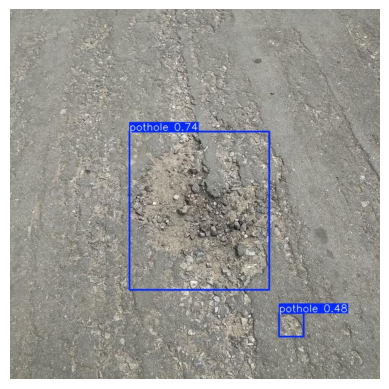

In [31]:
import cv2
import matplotlib.pyplot as plt

# Path to the saved result image
result_image_path = '/content/img-102_result.jpg'

# Load the image with detections
result_image = cv2.imread(result_image_path)

# Check if the image is loaded correctly
if result_image is None:
    print(f"Error: Unable to load image at {result_image_path}")
else:
    # Convert BGR to RGB for displaying with Matplotlib
    result_image_rgb = cv2.cvtColor(result_image, cv2.COLOR_BGR2RGB)

    # Display the image with Matplotlib
    plt.imshow(result_image_rgb)
    plt.axis('off')
    plt.show()
